# Contrastive Excitation Backprop Tutorial

Sam Greydanus. July 2017. MIT License.

In this notebook, we'll use excitation backprop (EB) to explore a pretrained VGG16 model in PyTorch 0.2.

For an in-depth explanation of EB, refer to [this paper](https://arxiv.org/abs/1608.00507). The [original code](https://github.com/jimmie33/Caffe-ExcitationBP) is in Caffe.

In [1]:
import torch
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils

import numpy as np
import matplotlib.pyplot as plt

import os, sys ; sys.path.append('..')
import excitation_bp as eb

reseed = lambda: np.random.seed(seed=1) ; ms = torch.manual_seed(1) # for reproducibility
reseed()

## Load some data

Here we use a single pre-cropped 3x224x224 image, normalized and converted to a tensor.

In [2]:
# init a few bookkeeping variables
fig_dir = './figures/'
data_dir = './data/imagenet'


# make the dataloader
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir, transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])), batch_size=1)

## Forward pass

### Load the VGG16 model

The authors of the EB paper use the VGG16 model as an example. For consistency, we will too. For more information about the pretrained PyTorch VGG16 model, look [here](http://pytorch.org/docs/master/torchvision/models.html).

In [3]:
# torch has a clean api for loading this model
model = models.vgg16(pretrained=True)
_ = model.train(False) # put model in evaluation mode

# get imagenet class labels from local file
class_labels = []
with open('./data/imagenet/labels.txt', 'r') as f:
    for line in f:
        class_labels.append(line[:-1])

### Inspect the model

Notice that the model contains two main parts: 1) the `features` extractor and 2) the `classifier`. We'll generally inspect neurons living in layers (3) or (6) of `classifier`. We'll perform excitation backprop from these neurons to a target.

When `target=None` the EB function will backprop all the way to the input; otherwise, it will return the EB activation of the target layer.

In [4]:
list(model.modules())[0]

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

### Forward pass

We've chosen to use an image of a cat sitting next to a dog so that the model has two competing signals (`cat` and `dog`). In this case, the `dog` signal prevails and the network labels this image a `cocker spaniel`.

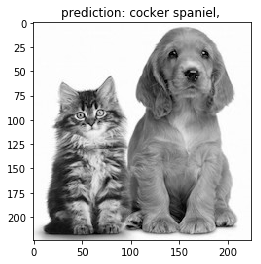

In [5]:
data = train_loader.dataset[0][0] # there's just one example image in the data directory. You can add more.

X = Variable(data.resize_(1,3,224,224), requires_grad=True)
y_hat = model(X)
class_id = y_hat.max(1)[1].data.numpy()[0]

plt.figure(figsize=(4,4))
im = np.mean(data.numpy().reshape(3,224,224), axis=0)

plt.title('prediction: {}'.format(class_labels[class_id][:16]), fontsize=12)
plt.imshow(im).set_cmap('gray') ; plt.show()

## Excitation backprop

### Enter EB mode
If you want to exit EB mode, just call `eb.use_eb(False)`

In [6]:
eb.use_eb(True) # put torch in EB mode

using excitation backprop autograd mode:
	->replacing torch.nn.functional.linear with eb_linear...
	->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...
	->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...
	->replacing torch.tanh & torch.nn.functional.tanh with eb_tanh...


### Cat vs. dog

Now we can ask the question, "_What pixels convinced the model to choose the label `cocker spaniel`?_"

In order to do this, we set the `cocker spaniel` index of the output layer to 1 and all other values to 0. Then we backpropagate this signal using EB.

In [7]:
layer_top = list(model.modules())[0].classifier[6] # output layer of network
target = list(model.modules())[0].features[4]


# excite the tabby cat neuron
top_dh_cat = torch.zeros(1, layer_top.out_features)
cat_id = 281 ; top_dh_cat[0, cat_id] = 1

print('performing EB on "{}" neuron...'.format(class_labels[cat_id][:16]))
cat_grad = eb.eb(model, X, layer_top, target=target, top_dh=top_dh_cat)


# excite the cocker spaniel neuron
top_dh_dog = torch.zeros(1, layer_top.out_features)
dog_id = 219 ; top_dh_dog[0, dog_id] = 1

print('performing EB on "{}" neuron...'.format(class_labels[dog_id][:16]))
dog_grad = eb.eb(model, X, layer_top, target=target, top_dh=top_dh_dog)
print('\nfinished.')

performing EB on "tabby, tabby cat" neuron...
performing EB on "cocker spaniel, " neuron...

finished.


**Visualizing results.** You'll notice that the `cocker spaniel` and `tabby cat` neurons don't produce heatmaps that look very different. In order to solve this, the authors of the paper propose a technique called _contrastive_ excitation backprop...

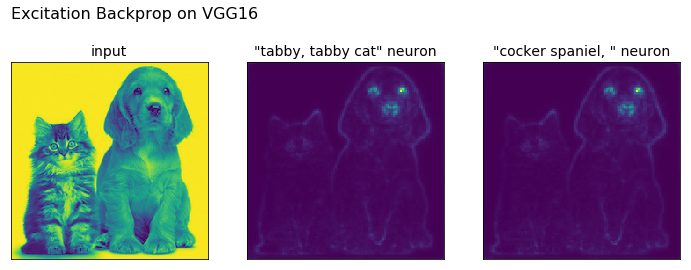

In [8]:
f = plt.figure(figsize=[12,4])

plt.subplot(1,3,1)
input_ = X.data.numpy()[0,:,:,:]
input_ = np.mean(input_,axis=0)
plt.title('input', fontsize=14) ;
plt.imshow(input_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(1,3,2)
cat_grad_ = cat_grad.numpy()[0,:,:,:]
cat_grad_ = np.mean(cat_grad_, axis=0)
title = '"{}" neuron'.format(class_labels[cat_id][:16])
plt.title(title, fontsize=14) ;
plt.imshow(cat_grad_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(1,3,3)
dog_grad_ = dog_grad.numpy()[0,:,:,:]
dog_grad_ = np.mean(dog_grad_, axis=0)
title = '"{}" neuron'.format(class_labels[dog_id][:16])
plt.title(title, fontsize=14)
plt.imshow(dog_grad_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

f.text(0.125, 1.01, 'Excitation Backprop on VGG16', ha='left', va='center', fontsize=16)
plt.show(f)
f.savefig('{}vgg16-eb.png'.format(fig_dir), bbox_inches='tight')

## Contrastive excitation backprop

**Intuition.** The idea of contrastive EB is to backprop first a positive signal and then a negative signal from the neuron of interest and display the sum of the two. The results can be loosely interpreted as the (un-normalized) probabilities that a given pixel will:
* excite the neuron.
* not inhibit the neuron.

**Under the hood.** This process requires 1) sending both a positive and a negative signal through the layer immediately below the neuron of interest 2) summing these signals and 3) doing EB with this signal through the remaining layers to the target layer or input.

As a result, the `contrastive_eb` function requires an extra parameter, `layer_second` which corresponds to the layer of hidden activations immediately below the current layer of activations.

**Normalization.** Regular EB should produce an output that is automatically normalized to 1. Contrastive EB has no such guarantee, so interpreting it as a probability distribution is hand-wavy.

In [9]:
layer_top = list(model.modules())[0].classifier[6] # output layer of network
layer_second = list(model.modules())[0].classifier[3] # need this for contrastive eb
target = list(model.modules())[0].features[4]


# excite the tabby cat neuron
top_dh_cat = torch.zeros(1, layer_top.out_features)
cat_id = 281 ; top_dh_cat[0, cat_id] = 1

print('performing contrastive EB on "{}" neuron...'.format(class_labels[cat_id][:16]))
cat_grad = eb.contrastive_eb(model, X, layer_top, layer_second, target=target, top_dh=top_dh_cat)


# excite the cocker spaniel neuron
top_dh_dog = torch.zeros(1, layer_top.out_features)
dog_id = 219 ; top_dh_dog[0, dog_id] = 1

print('performing contrastive EB on "{}" neuron...'.format(class_labels[dog_id][:16]))
dog_grad = eb.contrastive_eb(model, X, layer_top, layer_second, target=target, top_dh=top_dh_dog)
print('\nfinished.')

performing contrastive EB on "tabby, tabby cat" neuron...
performing contrastive EB on "cocker spaniel, " neuron...

finished.


**Visualizing results.** You'll notice that the results are _much_ better for contrastive EB. Now the `tabby cat` and `cocker spaniel` regions of the image are entirely separable.

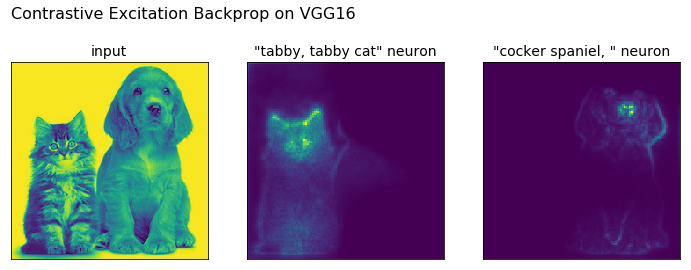

In [10]:
f = plt.figure(figsize=[12,4])

plt.subplot(1,3,1)
input_ = X.data.numpy()[0,:,:,:]
input_ = np.mean(input_,axis=0)
plt.title('input', fontsize=14) ;
plt.imshow(input_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(1,3,2)
cat_grad_ = cat_grad.numpy()[0,:,:,:]
cat_grad_ = np.mean(cat_grad_, axis=0)
title = '"{}" neuron'.format(class_labels[cat_id][:16])
plt.title(title, fontsize=14) ;
plt.imshow(cat_grad_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(1,3,3)
dog_grad_ = dog_grad.numpy()[0,:,:,:]
dog_grad_ = np.mean(dog_grad_, axis=0)
title = '"{}" neuron'.format(class_labels[dog_id][:16])
plt.title(title, fontsize=14)
plt.imshow(dog_grad_)
plt.gca().axes.get_xaxis().set_visible(False) ; plt.gca().axes.get_yaxis().set_visible(False)

f.text(0.125, 1.01, 'Contrastive Excitation Backprop on VGG16', ha='left', va='center', fontsize=16)
plt.show(f)
f.savefig('{}vgg16-contrast-eb.png'.format(fig_dir), bbox_inches='tight')

## Contrastive EB on pooling layers

According to the [EB paper](https://arxiv.org/abs/1608.00507):
> Neurons at higher-level layers have larger receptive fields and strides. Thus,
they can capture larger areas but with lower spatial accuracy. Neurons at lower layers
tend to more precisely localize features at smaller scale.

Here we obtain a visualization of the `tabby cat` activations for the input image and the first four pooling layers, similar to Figure 3 of the paper. Note that the pooling images are obtained by taking the sum over all pooling layers along the pooling dimension.

In [11]:
layer_top = list(model.modules())[0].classifier[6]  # output layer of network
layer_second = list(model.modules())[0].classifier[3]  # need this for contrastive eb
pool1 = list(model.modules())[0].features[4]
pool2 = list(model.modules())[0].features[9]
pool3 = list(model.modules())[0].features[16]
pool4 = list(model.modules())[0].features[23]
pool5 = list(model.modules())[0].features[30] # gets too coarse

pools = [None, pool1, pool2, pool3, pool4] # signal gets backpropped to input when target is None
pool_names = ['input gradient', 'pool1 gradient', 'pool2 gradient', 'pool3 gradient', 'pool4 gradient']


# excite an output neuron (tabby cat in this case)
top_dh = torch.zeros(1, layer_top.out_features)
unit_id = 281 ; top_dh[0, unit_id] = 1

#### PERFORM EB ON EACH MAXPOOL LAYER ####
grads = []
for i, p in enumerate(pools):
    print('performing contrastive EB on "{}" neuron to pool{}...'.format(class_labels[unit_id][:16], i))
    g = eb.contrastive_eb(model, X, layer_top, layer_second, target=p, top_dh=top_dh)
    grads.append(g)

performing contrastive EB on "tabby, tabby cat" neuron to pool0...
performing contrastive EB on "tabby, tabby cat" neuron to pool1...
performing contrastive EB on "tabby, tabby cat" neuron to pool2...
performing contrastive EB on "tabby, tabby cat" neuron to pool3...
performing contrastive EB on "tabby, tabby cat" neuron to pool4...


**Visualizing results.** The input gradient reconstructs some of the cat's fur texture. The 3rd pooling layer, meanwhile, accentuates the triangular blob of the cat's head and ears.

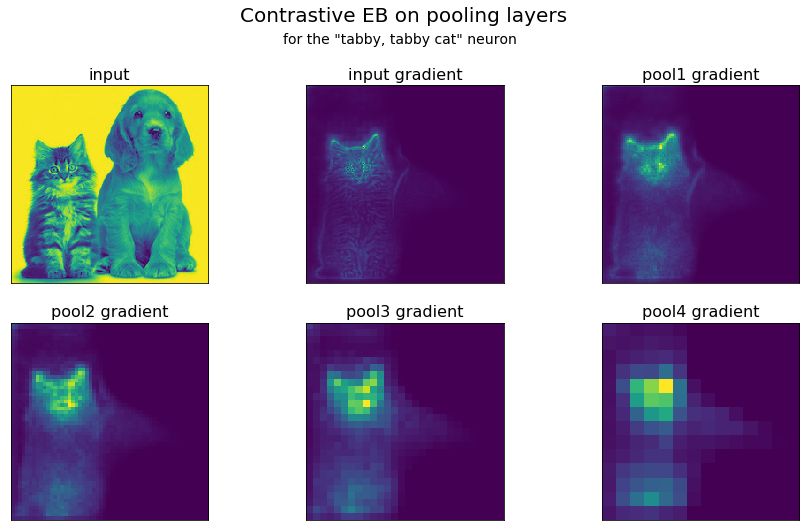

In [12]:
pool_imgs = [X.data] + grads
titles = ['input'] + pool_names
h = 3
v = 2
f = plt.figure(figsize=[5*h,4*v])
for i in range(v):
    for j in range(h):
        id = h*i + (j+1)
        if id-1 < len(pool_imgs):
            plt.subplot(v, h, id)
            plt.gca().axes.get_xaxis().set_visible(False)
            plt.gca().axes.get_yaxis().set_visible(False)

            img_ = pool_imgs[id-1].numpy()[0,:,:,:]
            img_ = np.mean(img_, axis=0)
            plt.title(titles[id-1], fontsize=16)
            
            plt.imshow(img_)

title = 'Contrastive EB on pooling layers'
subtitle = 'for the "{}" neuron'.format(class_labels[unit_id][:16])
f.text(0.36, 1.0, title, ha='left', va='center', fontsize=20)
f.text(0.4, .96, subtitle, ha='left', va='center', fontsize=14)
plt.show(f)
f.savefig('{}vgg16-pooling-eb.png'.format(fig_dir), bbox_inches='tight')

## Contrastive EB on hidden layer neurons

**Receptive fields.** One can also use EB to ask what makes _hidden_ neurons fire. In this case, the answer is less obvious; these neurons have not been trained to respond to, say, tabby cats. Instead, they might react to parts of paws, ears, or fur textures. _Interpreting what makes a hidden neuron fire is a major challenge in explainable AI!_ 

Here, we use EB to explore five randomly chosen neurons in the second-to-topmost layer of the model. You'll notice that they each have a very different focus.

**Convolutional layers.** You can do the same thing with activations produced by max-pooling and convolutional layers. These neurons will have smaller receptive fields if they are drawn from lower in the model and vice versa.

In [13]:
layer_top = list(model.modules())[0].classifier[3] # last hidden layer of network
layer_second = list(model.modules())[0].classifier[0] # need this for contrastive eb
target = None # signal gets backpropped all the way to the input image when this is None
top_layer_size = [1,4096]

top_dh1, ix1 = eb.explore_random_unit(top_layer_size)
top_dh2, ix2 = eb.explore_random_unit(top_layer_size)
top_dh3, ix3 = eb.explore_random_unit(top_layer_size)
top_dh4, ix4 = eb.explore_random_unit(top_layer_size)
top_dh5, ix5 = eb.explore_random_unit(top_layer_size)

top_dhs = [top_dh1, top_dh2, top_dh3, top_dh4, top_dh5]
ixs = [ix1, ix2, ix3, ix4, ix5]
dh_names = ['neuron at {}'.format(str(ix)) for ix in ixs]

#### PERFORM EB FOR SEVERAL RANDOMLY-SELECTED HIDDEN NEURONS ####
grads = []
for i, dh in enumerate(top_dhs):
    print('performing contrastive EB on neuron at {} of topmost hidden layer...'.format(str(ixs[i])))
    g = eb.contrastive_eb(model, X, layer_top, layer_second, target=target, top_dh=dh)
    grads.append(g)

performing contrastive EB on neuron at (0, 1061) of topmost hidden layer...
performing contrastive EB on neuron at (0, 235) of topmost hidden layer...
performing contrastive EB on neuron at (0, 3980) of topmost hidden layer...
performing contrastive EB on neuron at (0, 1096) of topmost hidden layer...
performing contrastive EB on neuron at (0, 3839) of topmost hidden layer...


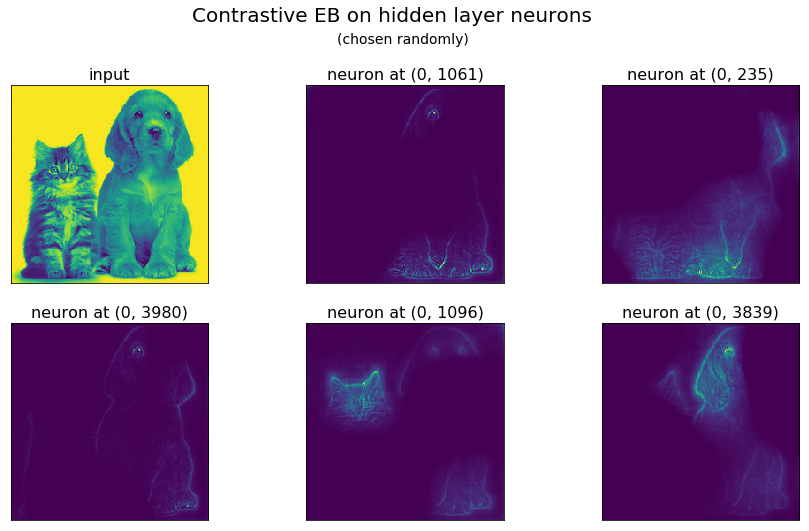

In [14]:
dh_imgs = [X.data] + grads
titles = ['input'] + dh_names
h = 3
v = 2
f = plt.figure(figsize=[5*h,4*v])
for i in range(v):
    for j in range(h):
        id = h*i + (j+1)
        if id-1 < len(dh_imgs):
            plt.subplot(v, h, id)
            plt.gca().axes.get_xaxis().set_visible(False)
            plt.gca().axes.get_yaxis().set_visible(False)

            img_ = dh_imgs[id-1].numpy()[0,:,:,:]
            img_ = np.mean(img_, axis=0)
            plt.title(titles[id-1], fontsize=16)
            
            plt.imshow(img_)

title = 'Contrastive EB on hidden layer neurons'
subtitle = '(chosen randomly)'.format(class_labels[unit_id][:16])
f.text(0.315, 1.0, title, ha='left', va='center', fontsize=20)
f.text(0.45, .96, subtitle, ha='left', va='center', fontsize=14)
plt.show(f)
f.savefig('{}vgg16-hidden-eb.png'.format(fig_dir), bbox_inches='tight')